In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train_data.csv
/kaggle/input/titanic/test_data.csv


# Importing important libraries

In [2]:
from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler
import seaborn as sns

## Simulating data using sklearn 

<AxesSubplot:>

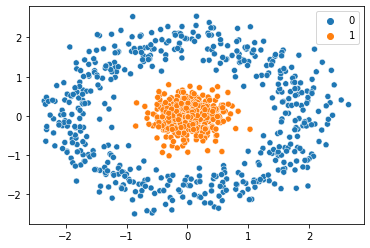

In [3]:
# Generate sample data
X, y = make_circles(n_samples=1000, factor=0.009, noise=0.15)

#-------------------------------------------------------------
ads_arr = StandardScaler().fit_transform(X)
sns.scatterplot(x=ads_arr[:,0],y=ads_arr[:,1],hue=y)

# DBSCAN from scratch

## UDFs for calculation of distances

In [4]:
#distance calculation UDF
def minkowski_(point_a,point_b,p=2):
    
    if p==1:
        print('----> Manhattan')
        dist = np.sum(abs(point_a-point_b))
        print('Manual Distance :',dist)
    elif p==2:
        #print('----> Euclidean')
        dist = np.sqrt(np.sum(np.square(point_a-point_b)))
        #print('Manual Distance :',dist)
        
    return dist

#------------------------------------------------------------------
#UDF for Calculation of distance from a point to every ther point
def distance_to_all(curr_vec,data,p_=2):

    #curr_vec = X_arr[0] #example
    distance_list = []
    #data = X_arr[0:5]

    for vec_idx in range(len(data)):
        dist = minkowski_(point_a=curr_vec,point_b=data[vec_idx],p=p_)
        distance_list.append(dist)

    return distance_list

## UDF for calculating the core, border and noisy point along with directly density reachable mapping of each point

In [5]:


def core_border_noise_mapping(data=ads_arr,min_points=10,epsilon=0.38):
    
    #Initializing trays for collecting labels & dictionaries for key-value combinations
    core = []
    interim = []
    density_reachable = []
    idx_dict = {} #Mapping of each point to its directly density reachable points (within epsilon)
    nmin_dict= {} #Count of total density reachable points within epsilon for each point
    
    
    #-----------------------------------------------------------------------------------------
    for idx in range(len(data)): #For each point of data

        current_arr = data[idx]
        current_to_all = np.array(distance_to_all(curr_vec=current_arr,data=data,p_=2)) #Calculating distance

        inside_ = np.argwhere(current_to_all<epsilon).ravel() #Filtering for within epsilon (not inclusive)
        #print('Index :',idx,'- Len :',len(inside_))
        length = len(inside_)
        idx_dict.update({idx : inside_}) #Updating the points which are within eps wrt 'idx' point
        nmin_dict.update({idx : length}) #Updating the no of points which are within eps wrt 'idx' point

    #-----------------------------------------------------------------------------------------
    idx_dict_updated = {} #Copy of the mapping dict with removal of self distance (a point has 0 distance with itself)
    for key,val in idx_dict.items():
        val_ = val[val!=key]
        idx_dict_updated.update({key : val_})

    #-----------------------------------------------------------------------------------------
    #Classifying between Core and non-core (interim) points through nmin parameter
    for (key,value) in nmin_dict.items():

        if value>=min_points:
            core.append(key)
        elif value<=min_points:
            interim.append(key)

    #----------------------------------------------------
    print('Total core points :',len(core))
    print('Total interim points :',len(interim))

    #---------------------------------------------------- 
    #Calculating the directly density reachable points (All points which are within eps of any point)
    for key_ in idx_dict_updated.keys():

        val = list(idx_dict_updated[key_])
        density_reachable += val

    density_reachable = list(set(density_reachable)) #Unique through conversion to set
    print('Total density reachable points :',len(density_reachable))
    #density_reachable[0:4]

    #----------------------------------------------------
    noise = []
    border = []
    
    #Classifying between border and noisy points
    for idx in interim:
        if idx in density_reachable:
            border.append(idx)
        elif idx not in density_reachable:
            noise.append(idx)

    print('Total noisy points :', len(noise))
    print('Total border points :',len(border))
    #----------------------------------------------------
    
    return core,border,noise,idx_dict_updated


# Nearest Neighbour Graph (tuning epsilon value)
- Used to find out the the approximate epsilon value from a min_points available (distribution of each point's epsilon to accomodate n_min points) 
- The elbow point is our requirement

[Text(0.5, 0, 'No of Points'),
 Text(0, 0.5, 'Distance of kth neighbor'),
 Text(0.5, 1.0, 'Elbow Curve of kth distance-vs-point')]

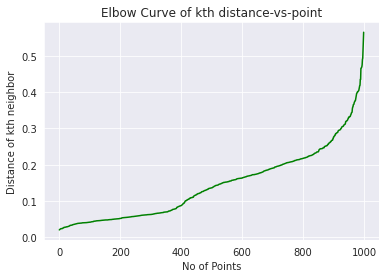

In [6]:
#!pip install kneed  #If not already installed
from sklearn.neighbors import NearestNeighbors #Nearest Neighbor Calculator
#from kneed import KneeLocator

nbrs = NearestNeighbors(n_neighbors=6,algorithm='auto',metric='minkowski',p=2,n_jobs=-1).fit(ads_arr)
distances, indices = nbrs.kneighbors(ads_arr)

#-----------------------------------------------------------------------------------------------------
distances = np.sort(distances[:,-1], axis=0)
i = np.arange(len(distances))
#knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

#-----------------------------------------------------------------------------------------------------
sns.set_style('darkgrid')
ax = sns.lineplot(x=range(0,len(ads_arr)),y=distances,color='g')
ax.set(xlabel='No of Points',ylabel='Distance of kth neighbor',title='Elbow Curve of kth distance-vs-point')
#knee.plot_knee()

### Insights :
For 6 nearest neighbours (including itself),the elbow occurs at around 0.3 epsilon value

## Invoking the above UDF to classify points into core, border and noise category + get the directly density reachable mapping

In [7]:
epsilon = 0.31 #Calculate through Nearest Neighbours Distance graph
min_points = 5

core,border,noise,idx_dict_updated = core_border_noise_mapping(data=ads_arr,min_points=min_points,epsilon=epsilon)

Total core points : 955
Total interim points : 45
Total density reachable points : 996
Total noisy points : 4
Total border points : 41


## UDF for expanding greedy search

In [8]:
def expand_clusters(point, neighbors_, border_, core_, idx_dict_updated_):
    
    #Starting of allotment of cluster
    clusters[point] = counter
    
    #print('Length of neighbor at START :',len(neighbors_)) ##

    i = 0 #Initializing
    
    #Total directly density reachable elements to cluster tray (gets updated automatically for density reachable & density connected)
    while i < len(neighbors_): 
        
        nextPoint = neighbors_[i]
        
        if (nextPoint in border_) and (nextPoint not in counter_assign): #In border AND not alloted already
            #print('For border :',nextPoint)
            clusters[nextPoint] = counter
            counter_assign.append(nextPoint) 
        
        elif (nextPoint in core_) and (nextPoint not in counter_assign): #In core AND not alloted already
            #print('For Core :',nextPoint)
            clusters[nextPoint] = counter
            
            counter_assign.append(nextPoint)
            #print('Next point else :',nextPoint)
            
            nextNeighbors = list(idx_dict_updated_[nextPoint]) 
            
            #print('---- New neigbors :',len(nextNeighbors)) ##
            
            neighbors_ = neighbors_ + nextNeighbors #Updating with new list of directly density reachable since the new addition to cluster was a core point
            
            #print('Length of neighbor at end :',len(neighbors_)) ##
        
        i += 1 #Next element in the tray
        
        #return clusters_ 

## Implementation of DBSCAN loop

In [9]:
clusters = np.array([np.nan]*len(ads_arr)) #Initializing clusters with required size and nan value 
print('Cluster length :',clusters.shape)

counter = 0 #Start of allotment counter
counter_assign = [] #Counter for assignment (To prevent over-write of clusters)

for idx in range(len(ads_arr)): #For each data point
    
    if idx not in counter_assign: #Checking if that point is not assigned already

        print('---------------------------------------- idx :',idx)
        #print('------------------ counter :',counter)
        if idx in noise: #If index of the point in noise list, no allotment required
            #print('noise :',idx)
            clusters[idx] = -1 #Allotment for noisy points
            counter_assign.append(idx)

        else : #If core or border point
            #print('Core :',idx)
            
            print('------------------ counter :',counter)
            
            neighbors = list(idx_dict_updated[idx]) #Directly density reachable for that point
            
            expand_clusters(point=idx,
                            neighbors_=neighbors,
                            border_=border,
                            core_=core,
                            idx_dict_updated_=idx_dict_updated) #Greedy search algo to allot cluster till the edge
            
            counter += 1 #Changing cluster label value



Cluster length : (1000,)
---------------------------------------- idx : 0
------------------ counter : 0
---------------------------------------- idx : 1
------------------ counter : 1
---------------------------------------- idx : 10
------------------ counter : 2
---------------------------------------- idx : 155
------------------ counter : 3
---------------------------------------- idx : 174
---------------------------------------- idx : 231
------------------ counter : 4
---------------------------------------- idx : 359
---------------------------------------- idx : 397
---------------------------------------- idx : 425
------------------ counter : 5
---------------------------------------- idx : 477
---------------------------------------- idx : 612
------------------ counter : 6
---------------------------------------- idx : 739
------------------ counter : 7
---------------------------------------- idx : 805
------------------ counter : 8
--------------------------------------

## Info regarding clusters formed through manual implementation 

In [10]:
print('Total clusters :',len(np.unique(clusters)))
print('Unique cluster values :',np.unique(clusters))

Total clusters : 11
Unique cluster values : [-1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]


## Plotting the sccater plot for manual DBSCAN labels

<AxesSubplot:>

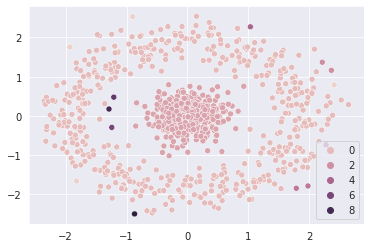

In [11]:
sns.scatterplot(x=ads_arr[:,0],y=ads_arr[:,1],hue=clusters)

# Sklearn benchmarking

In [12]:
from sklearn.cluster import DBSCAN

#-------------------------------------------------------------------------------------
dbscan = DBSCAN(eps=epsilon,min_samples=min_points,metric='euclidean',n_jobs=-1)
dbscan.fit(ads_arr)
dbscan_labels = dbscan.labels_

## Scatterplot for sklearn DBSCAN labels

<AxesSubplot:>

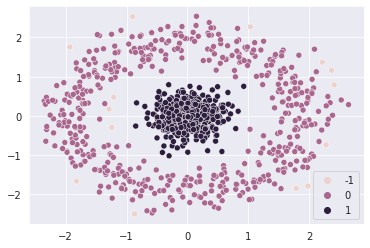

In [13]:
sns.scatterplot(x=ads_arr[:,0],y=ads_arr[:,1],hue=dbscan_labels)

## Insights : 
- The sklearn implementation and the manual implementation seem to be in sync as the results are similar, hence the logic implemented here is correct

# END